## Contents
-  [1.Importing Libraries](#1)
-  [2.Dataset Management](#2)
    -  [2.1.Downloading and Extracting Dataset](#2.1)
    -  [2.2.Visualizing Dataset](#2.2)
    -  [2.3.Splitting Dataset](#2.3)
    -  [2.4.Pytorch DataLoaders](#2.4)
-  [3.Initializing pre-trained model](#3)
-  [4.Training](#4)
-  [5.Plotting Results](#5)
    -  [5.1.Plotting Loss vs MiniBatch](#5.1)
    -  [5.2.Plotting Accuracy vs MiniBatch](#5.2)
    -  [5.3.Plotting Loss vs Epoch](#5.3)
    -  [5.4.Plotting Accuracy vs Epoch](#5.4)
    -  [5.5.Plotting F1 Score vs Epoch](#5.5)
    -  [5.6.Plotting Recall vs Epoch](#5.6)
    -  [5.7.Plotting Precision vs Epoch](#5.7)
    -  [5.8.Plotting Kappa vs Epoch](#5.8)
-  [6.Testing](#6)

### 1.Importing Libraries <a class="anchor" id="1"></a>

In [1]:
!pip install timm
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 2.3 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
from sklearn import cluster
from zipfile import ZipFile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import os
import random
import pickle

torch.cuda.empty_cache()
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (10,10)


### 2.Dataset Management <a class="anchor" id="2"></a>

#### 1.Downloading and Extracting Dataset <a class="anchor" id="2.1"></a>

In [3]:
import pandas as pd
path = "/kaggle/input/electricity-dataset/"
labels = {os.listdir(path)[i]:i for i in range(3)}


train_img = []
train_label = []

test_img = []
test_label = []

val_img = []
val_label = []

for i in os.listdir(path):
    for j in os.listdir(path+i):
        if "test" in j:
            test_img+=[path+i+'/'+j+'/'+k for k in os.listdir(path+i+'/'+j)]
            test_label+=[labels[i]]*len(os.listdir(path+i+'/'+j))
            
        else:
            train_img+=[path+i+'/'+j+'/'+k for k in os.listdir(path+i+'/'+j)]
            train_label+=[labels[i]]*len(os.listdir(path+i+'/'+j))
            val_img+=train_img[-4:]
            val_label+=train_label[-4:]
            
            train_img = train_img[:-4]
            train_label = train_label[:-4]

#### 2.Visualizing Dataset <a class="anchor" id="2.2"></a>

In [4]:
from collections import Counter
Counter(train_label)

Counter({0: 60, 1: 60, 2: 60})

#### 3.Splitting Dataset <a class="anchor" id="2.3"></a>

#### 4.Pytorch DataLoaders <a class="anchor" id="2.4"></a>

In [5]:
from PIL import Image

class Dataset(Dataset):
    def __init__(self,x,y,transform = 'T.Resize((224,224))'):
        self.transform = transform
        self.x = x
        self.y = y 
        self.len = len(x)
   
    def __len__(self):
        return self.len
    
    def __getitem__(self,i):
        img = Image.open(self.x[i]).convert('RGB')
        return torch.FloatTensor(np.asarray(self.transform(img))),torch.LongTensor([self.y[i]])


batch_size = 3

transforms_train = T.Compose([
        T.Resize((224,224)),
#         T.RandomRotation(degrees=(-10, 10)),
#         T.RandomHorizontalFlip(),
#         T.RandomVerticalFlip(),
        T.ToTensor(),
#         T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transforms_test = T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
#         T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = Dataset(train_img, train_label,transform =transforms_train)
validation_dataset = Dataset(val_img, val_label,transform =transforms_test)
test_dataset = Dataset(test_img, test_label,transform =transforms_test)

train_dataloader = DataLoader(train_dataset , batch_size = batch_size , shuffle = True )
validation_dataloader = DataLoader(validation_dataset , batch_size = batch_size , shuffle = True )
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , shuffle = True )

In [6]:
next(iter(test_dataloader))

[tensor([[[[0.8118, 0.8196, 0.8392,  ..., 0.4235, 0.4471, 0.3020],
           [0.8196, 0.8157, 0.8314,  ..., 0.4235, 0.4392, 0.3020],
           [0.8235, 0.8235, 0.8235,  ..., 0.4157, 0.4275, 0.3176],
           ...,
           [0.1569, 0.1137, 0.1176,  ..., 0.5451, 0.5922, 0.6588],
           [0.7451, 0.7333, 0.7412,  ..., 0.8706, 0.8706, 0.8863],
           [0.8471, 0.8392, 0.8431,  ..., 0.8431, 0.8431, 0.8392]],
 
          [[0.8196, 0.8275, 0.8431,  ..., 0.5804, 0.5490, 0.3608],
           [0.8196, 0.8157, 0.8353,  ..., 0.5882, 0.5529, 0.3725],
           [0.8196, 0.8196, 0.8235,  ..., 0.5922, 0.5569, 0.4039],
           ...,
           [0.1569, 0.1137, 0.1176,  ..., 0.5333, 0.5804, 0.6471],
           [0.7451, 0.7333, 0.7373,  ..., 0.8627, 0.8667, 0.8784],
           [0.8431, 0.8392, 0.8392,  ..., 0.8431, 0.8431, 0.8431]],
 
          [[0.8157, 0.8235, 0.8392,  ..., 0.8471, 0.8039, 0.5373],
           [0.8196, 0.8157, 0.8314,  ..., 0.8549, 0.8039, 0.5412],
           [0.8157, 0.81

### 3.Initializing pre-trained model <a class="anchor" id="3"></a>

In [7]:
model_name = "vit_large_patch16_224"
class ViTBase16(nn.Module):
    def __init__(self, n_classes):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model(model_name, pretrained=True)
        
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x


model = ViTBase16(3)
for param in model.parameters():
    param.requires_grad = True

### 4.Training <a class="anchor" id="4"></a>

In [8]:
lr = 0.0015
epoch = 30
train_dataset_size = train_dataset.__len__()
validation_dataset_size = validation_dataset.__len__()
train_n_minibatches = train_dataloader.__len__()
validation_n_minibatches = validation_dataloader.__len__()

device = 'cuda'
model.to(device)
loss_history = [[],[]] #[[train], [validation]]
accuracy_history = [[],[]] #[[train], [validation]]
# prec_history = [[],[]] #[[train], [validation]]
# recall_history = [[],[]] #[[train], [validation]]
# f1_history = [[],[]] #[[train], [validation]]
# support_history = [[],[]] #[[train], [validation]]

results = [[],[]]
kappa = [[],[]]

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(),lr = lr)



In [9]:
from sklearn.metrics import precision_recall_fscore_support, cohen_kappa_score

best_val_score = 10000000
best_acc_score = 0

for e in range(epoch):
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    y_all_train_true = []
    y_all_train_pred = []
    y_all_val_true = []
    y_all_val_pred = []
    
    for batch_idx , (x ,y) in enumerate(train_dataloader):
        model.train() # Setting mode to train
        optimizer.zero_grad()
        x , y = x.to(device) , y.to(device)
        y_pred = model(x).to(device)
        
        y_all_train_true+=y.cpu().detach().view(-1,).tolist()
        y_all_train_pred+=torch.argmax(y_pred, dim=1).detach().tolist()
        
        # Calculating Loss
        loss = criterion(y_pred,y.reshape(x.shape[0]))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 3)
        optimizer.step()
        loss_history[0].append(float(loss.detach()))
        
        #Calaculating Accuracy
        correct = 0
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = y.cpu().detach().numpy().tolist()
        for i in range(x.shape[0]):
            n = 0
            n = y_pred[i].index(max(y_pred[i]))
            if n == y[i][0]:
                correct = correct + 1
        accuracy_history[0].append((correct/x.shape[0])*100)
        
        if batch_idx % (len(train_dataloader)//2) == 0:
            # Printing Log
            print(f'LOSS for EPOCH {e+1} BATCH {batch_idx}/{train_n_minibatches} TRAIN LOSS : {loss_history[0][-1]}',end = ' ')
            print(f'TRAIN ACCURACY : {accuracy_history[0][-1]}',end = ' ')
            with torch.no_grad():
                # Calculating loss and accuracy for validation
                model.eval()
                for _batch_idx_ , (x ,y) in enumerate(validation_dataloader):
                    x , y = x.to(device) , y.to(device)
                    y_pred = model(x).to(device)
                    
                    y_all_val_true+=y.cpu().detach().view(-1,).tolist()
                    y_all_val_pred+=torch.argmax(y_pred, dim=1).detach().tolist()
                    
                    validation_loss = criterion(y_pred,y.reshape(x.shape[0]))
                    loss_history[1].append(float(validation_loss.detach()))
                    
                    correct = 0
                    y_pred = y_pred.cpu().detach().numpy().tolist()
                    y = y.cpu().detach().numpy().tolist()      
                    for i in range(x.shape[0]):
                        n = 0
                        n = y_pred[i].index(max(y_pred[i]))
                        if n == y[i][0]:
                            correct = correct + 1
                    accuracy_history[1].append((correct/x.shape[0])*100)
                        
                    
                print(f'VALIDATION LOSS : {sum(loss_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}',end = ' ')
                print(f'VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}')
    
    # Saving the model progress
    torch.save(model.state_dict(),model_name)

    n_validation_losses = validation_n_minibatches
    x = sum(loss_history[1][-1:-1*n_validation_losses-1:-1])/n_validation_losses
    x_ = sum(loss_history[1][-1:-1*n_validation_losses-1:-1])/n_validation_losses
    if best_val_score>x:
        best_val_score = x
        torch.save(model.state_dict(),model_name+'_best_loss')
    
    if best_acc_score<x_:
        best_acc_score = x_
        torch.save(model.state_dict(),model_name+'_best_acc')
    
    results[0].append(precision_recall_fscore_support(y_all_train_true,y_all_train_pred))
    results[1].append(precision_recall_fscore_support(y_all_val_true,y_all_val_pred))

    kappa[0].append(cohen_kappa_score(y_all_train_true,y_all_train_pred))
    kappa[1].append(cohen_kappa_score(y_all_val_true,y_all_val_pred))
    
    #Log for e+1th epoch
    print(f'--------------------------------------------------------------------------------------------')
    print(f'Loss for EPOCH {e+1}  TRAIN LOSS : {sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}',end = ' ')
    print(f'TRAIN PREC : {results[0][-1][0]} RECALL : {results[0][-1][1]} F1 : {results[0][-1][2]}',end=" ")
    print(f'ACC : {sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}', end=" ")
    print(f' KAPPA : {sum(kappa[0][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}')
    print(f'VALIDATION LOSS for EPOCH {e+1} : {sum(loss_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}',end = ' ')
    print(f'VALIDATION PREC : {results[1][-1][0]} RECALL : {results[1][-1][1]} F1 : {results[1][-1][2]}',end=" ")
    print(f' ACC : {sum(accuracy_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}',end=" ")
    print(f' KAPPA : {sum(kappa[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}')
    print('---------------------------------------------------------------------------------------------')

---------------------------------------EPOCH 1-------------------------------------------
LOSS for EPOCH 1 BATCH 0/60 TRAIN LOSS : 1.3607540130615234 TRAIN ACCURACY : 66.66666666666666 VALIDATION LOSS : 1.199761301279068 VALIDATION ACCURACY : 33.33333333333333
LOSS for EPOCH 1 BATCH 30/60 TRAIN LOSS : 1.4093607664108276 TRAIN ACCURACY : 33.33333333333333 VALIDATION LOSS : 1.027686133980751 VALIDATION ACCURACY : 41.66666666666666
--------------------------------------------------------------------------------------------
Loss for EPOCH 1  TRAIN LOSS : 1.021723358333111 TRAIN PREC : [0.453125   0.50746269 0.59183673] RECALL : [0.48333333 0.56666667 0.48333333] F1 : [0.46774194 0.53543307 0.53211009] ACC : 51.11111111111112  KAPPA : 0.06666666666666668
VALIDATION LOSS for EPOCH 1 : 1.027686133980751 VALIDATION PREC : [0.44444444 0.25       0.42857143] RECALL : [0.5   0.25  0.375] F1 : [0.47058824 0.25       0.4       ]  ACC : 41.66666666666666  KAPPA : 0.015625
---------------------------

### 5.Plotting results <a class="anchor" id="4"></a>

#### 1.Plotting Loss vs MiniBatch<a class="anchor" id="5.1"></a>

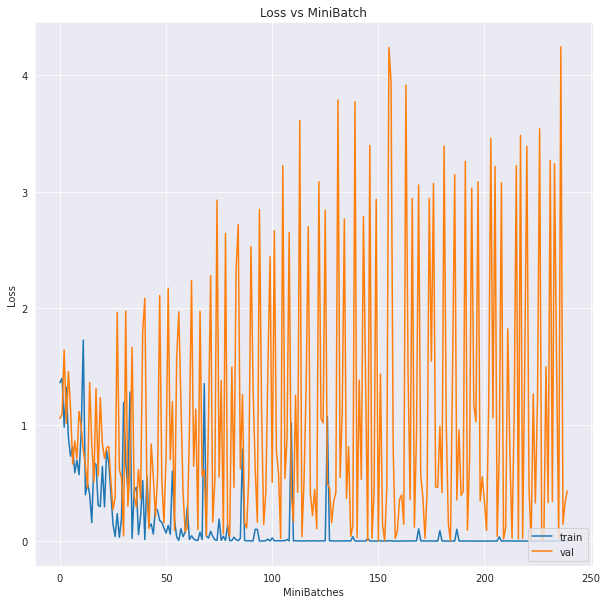

In [10]:
sns.lineplot(x=range(len(loss_history[1])),y=loss_history[0][::len(loss_history[0])//len(loss_history[1])][:len(loss_history[1])])
sns.lineplot(x=range(len(loss_history[1])),y=loss_history[1])

plt.legend(loc='lower right', labels=['train', 'val'])
plt.title("Loss vs MiniBatch")
plt.xlabel('MiniBatches')
plt.ylabel('Loss')


plt.show()


#### 2.Plotting Accuracy vs MiniBatch<a class="anchor" id="5.2"></a>

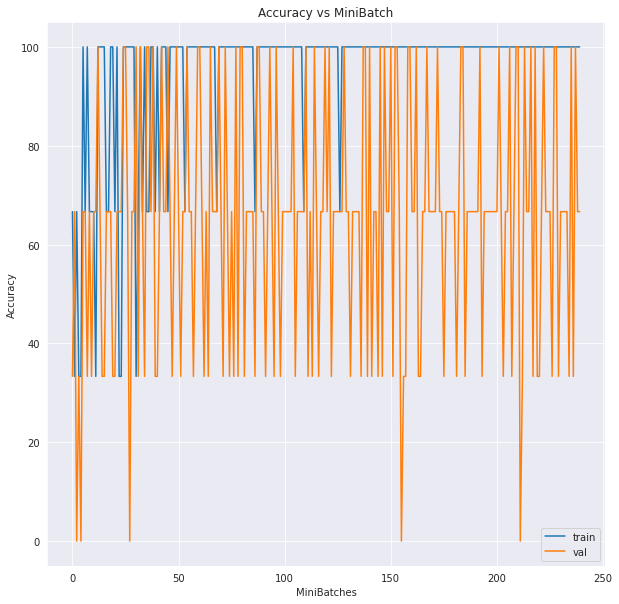

In [11]:
sns.lineplot(x=range(len(accuracy_history[1])),y=accuracy_history[0][::len(accuracy_history[0])//len(accuracy_history[1])][:len(accuracy_history[1])])
sns.lineplot(x=range(len(accuracy_history[1])),y=accuracy_history[1])

plt.legend(loc='lower right', labels=['train', 'val'])
plt.title("Accuracy vs MiniBatch")
plt.xlabel('MiniBatches')
plt.ylabel('Accuracy')

plt.show()


#### 3.Plotting Loss vs Epoch<a class="anchor" id="5.3"></a>

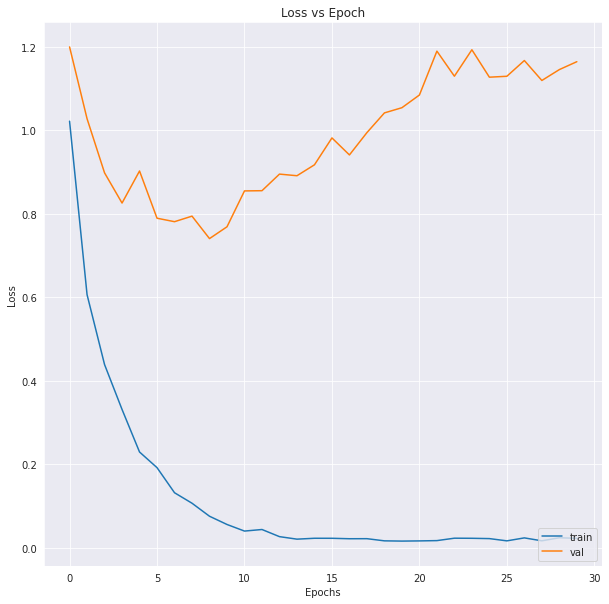

In [12]:
# Plotting Loss per epoch
loss_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in loss_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    loss_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in loss_history[1][i*validation_n_minibatches:(i+1)*validation_n_minibatches]:
        temp = temp + j
    loss_per_epoch[1].append(temp/validation_n_minibatches)    

sns.lineplot(x=range(len(loss_per_epoch[0])),y=loss_per_epoch[0])
sns.lineplot(x=range(len(loss_per_epoch[1])),y=loss_per_epoch[1])

plt.legend(loc='lower right', labels=['train', 'val'])
plt.title("Loss vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')


plt.show()

#### 4.Plotting Accuracy vs Epoch<a class="anchor" id="5.4"></a>

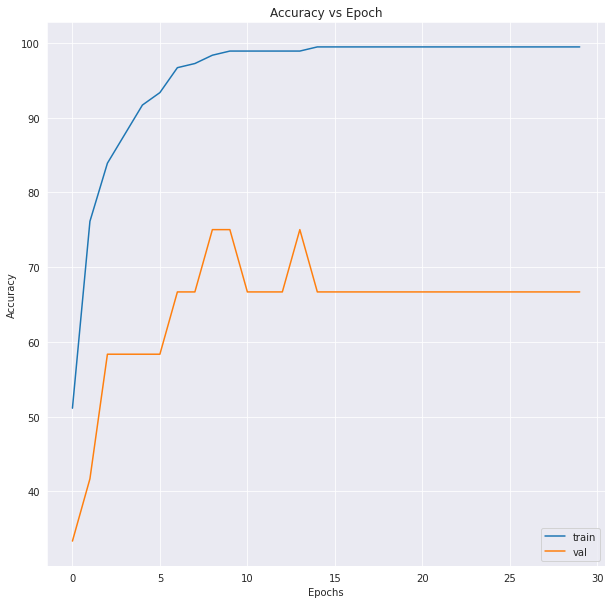

In [13]:
# Plotting Accuracy per epoch
accuracy_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in accuracy_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    accuracy_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in accuracy_history[1][i*validation_n_minibatches:(i+1)*validation_n_minibatches]:
        temp = temp + j
    accuracy_per_epoch[1].append(temp/validation_n_minibatches)    

sns.lineplot(x=range(len(accuracy_per_epoch[0])),y=accuracy_per_epoch[0])
sns.lineplot(x=range(len(accuracy_per_epoch[1])),y=accuracy_per_epoch[1])

plt.legend(loc='lower right', labels=['train', 'val'])
plt.title("Accuracy vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

#### 5.Plotting F1Score vs Epoch<a class="anchor" id="5.5"></a>

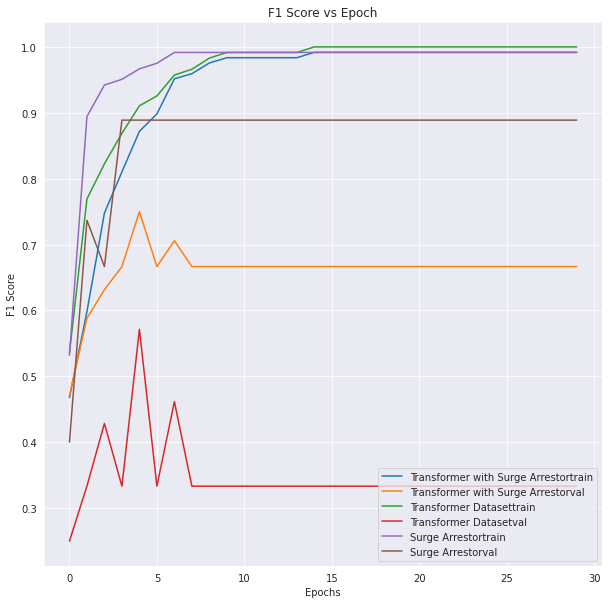

In [14]:
labels = {i:os.listdir(path)[i] for i in range(3)}

legend = []

for j in range(3):
    sns.lineplot(x=range(len(results[0])),y=[results[0][i][2][j] for i in range(len(results[0]))])
    sns.lineplot(x=range(len(results[1])),y=[results[1][i][2][j] for i in range(len(results[1]))])
    legend+=[labels[j]+'train', labels[j]+'val']



plt.legend(loc='lower right', labels=legend)
plt.title("F1 Score vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('F1 Score')


plt.show()

#### 6.Plotting Recall vs Epoch<a class="anchor" id="5.6"></a>

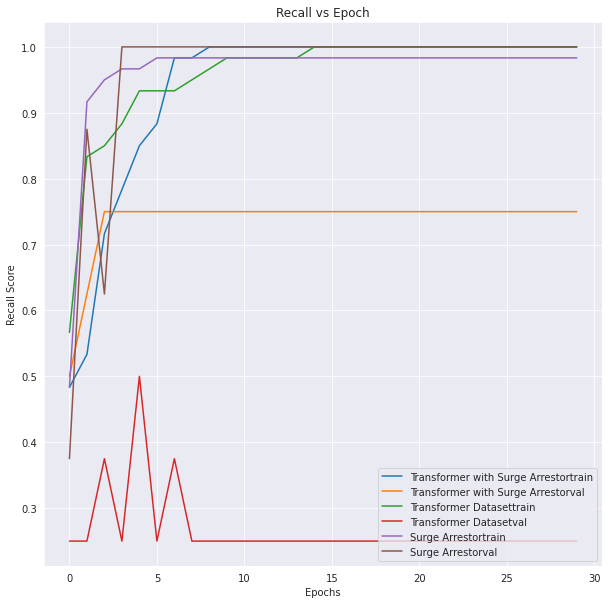

In [15]:
for j in range(3):
    sns.lineplot(x=range(len(results[0])),y=[results[0][i][1][j] for i in range(len(results[0]))])
    sns.lineplot(x=range(len(results[1])),y=[results[1][i][1][j] for i in range(len(results[1]))])


plt.legend(loc='lower right', labels=legend)
plt.title("Recall vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Recall Score')


plt.show()

#### 7.Plotting Precision vs Epoch<a class="anchor" id="5.7"></a>

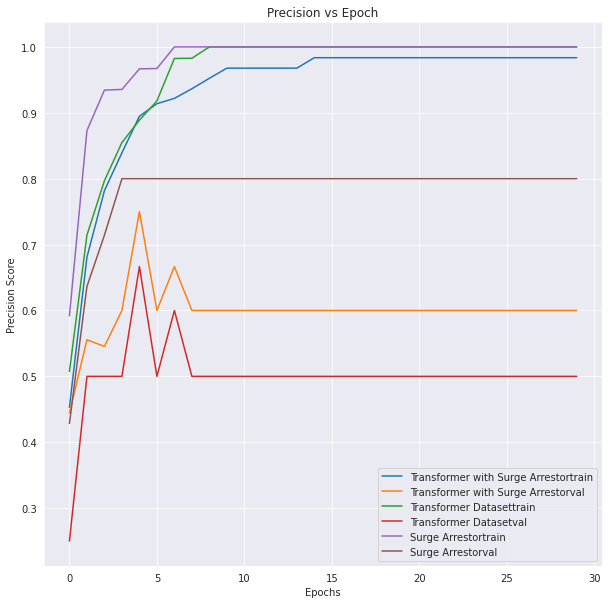

In [16]:
for j in range(3):
    sns.lineplot(x=range(len(results[0])),y=[results[0][i][0][j] for i in range(len(results[0]))])
    sns.lineplot(x=range(len(results[1])),y=[results[1][i][0][j] for i in range(len(results[1]))])


plt.legend(loc='lower right', labels=legend)
plt.title("Precision vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Precision Score')


plt.show()

#### 8.Plotting Kappa vs Epoch<a class="anchor" id="5.8"></a>

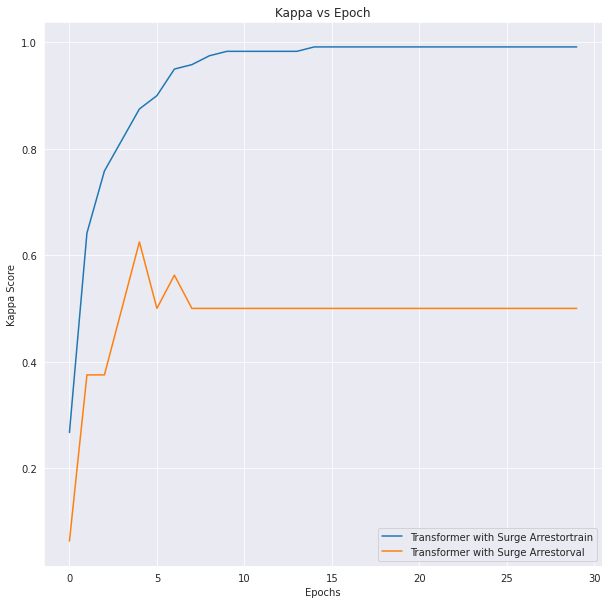

In [17]:

sns.lineplot(x=range(len(kappa[0])),y=kappa[0])
sns.lineplot(x=range(len(kappa[1])),y=kappa[1])


plt.legend(loc='lower right', labels=legend)
plt.title("Kappa vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Kappa Score')


plt.show()

### 6.Testing <a class="anchor" id="4"></a>

In [18]:
import gc

test_loss_history = []
test_accuracy_history = []
y_all_true = []
y_all_pred = []
#Testing the model on test dataset
# model = model.to('cuda')
model.eval()
for _batch_idx_ , (x ,y) in enumerate(test_dataloader):
    torch.cuda.empty_cache()
    x , y = x.to(device) , y.to(device)
    y_pred = model(x)
    test_loss = criterion(y_pred,y.reshape(x.shape[0]))
    test_loss_history.append(float(test_loss.detach()))
    correct = 0

    y_all_true+=y.cpu().detach().view(-1,).tolist()
    y_all_pred+=torch.argmax(y_pred, dim=1).detach().tolist()

    y_pred = y_pred.cpu().detach().numpy().tolist()
    y = y.cpu().detach().numpy().tolist()      
    for i in range(x.shape[0]):
        n = 0
        n = y_pred[i].index(max(y_pred[i]))
        if n == y[i][0]:
            correct = correct + 1
    test_accuracy_history.append((correct/len(y))*100)

    del x, y, y_pred, test_loss
    gc.collect()
                        
print(f'LOSS : {sum(test_loss_history)/len(test_loss_history)}  ACCURACY : {sum(test_accuracy_history)/len(test_accuracy_history)}')       

result = precision_recall_fscore_support(y_all_true,y_all_pred)

print(f"TEST PREC: {result[0]} RECALL: {result[1]} F1 SCORE: {result[2]} SUPPORT: {result[3]}")
print("KAPPA: ", cohen_kappa_score(y_all_true,y_all_pred))

LOSS : 0.45345733356791446  ACCURACY : 85.18518518518519
TEST PREC: [0.78947368 0.84210526 0.9375    ] RECALL: [0.83333333 0.88888889 0.83333333] F1 SCORE: [0.81081081 0.86486486 0.88235294] SUPPORT: [18 18 18]
KAPPA:  0.7777777777777778


In [19]:
model.load_state_dict(torch.load(model_name+"_best_loss"))

test_loss_history = []
test_accuracy_history = []
y_all_true = []
y_all_pred = []

#Testing the model on test dataset
# model = model.to('cuda')
model.eval()
for _batch_idx_ , (x ,y) in enumerate(test_dataloader):
    x , y = x.to(device) , y.to(device)
    y_pred = model(x)

    y_all_true+=y.cpu().detach().view(-1,).tolist()
    y_all_pred+=torch.argmax(y_pred, dim=1).detach().tolist()

    test_loss = criterion(y_pred,y.reshape(x.shape[0]))
    test_loss_history.append(float(test_loss.detach()))
    correct = 0
    y_pred = y_pred.cpu().detach().numpy().tolist()
    y = y.cpu().detach().numpy().tolist()      
    for i in range(x.shape[0]):
        n = 0
        n = y_pred[i].index(max(y_pred[i]))
        if n == y[i][0]:
            correct = correct + 1
    test_accuracy_history.append((correct/len(y))*100)

    del x, y, y_pred, test_loss
    gc.collect()

print(f'LOSS : {sum(test_loss_history)/len(test_loss_history)}  ACCURACY : {sum(test_accuracy_history)/len(test_accuracy_history)}')       

result = precision_recall_fscore_support(y_all_true,y_all_pred)

print(f"TEST PREC: {result[0]} RECALL: {result[1]} F1 SCORE: {result[2]} SUPPORT: {result[3]}")

print("KAPPA: ", cohen_kappa_score(y_all_true,y_all_pred))

LOSS : 0.4137995382770896  ACCURACY : 81.48148148148148
TEST PREC: [0.66666667 0.92857143 0.9375    ] RECALL: [0.88888889 0.72222222 0.83333333] F1 SCORE: [0.76190476 0.8125     0.88235294] SUPPORT: [18 18 18]
KAPPA:  0.7222222222222222


In [20]:
model.load_state_dict(torch.load(model_name+"_best_acc"))
test_loss_history = []
test_accuracy_history = []
y_all_true = []
y_all_pred = []

#Testing the model on test dataset
# model = model.to('cuda')
model.eval()
for _batch_idx_ , (x ,y) in enumerate(test_dataloader):
    torch.cuda.empty_cache()
    x , y = x.to(device) , y.to(device)
    y_pred = model(x)


    y_all_true+=y.cpu().detach().view(-1,).tolist()
    y_all_pred+=torch.argmax(y_pred, dim=1).detach().tolist()

    test_loss = criterion(y_pred,y.reshape(x.shape[0]))
    test_loss_history.append(float(test_loss.detach()))
    correct = 0
    y_pred = y_pred.cpu().detach().numpy().tolist()
    y = y.cpu().detach().numpy().tolist()      
    for i in range(x.shape[0]):
        n = 0
        n = y_pred[i].index(max(y_pred[i]))
        if n == y[i][0]:
            correct = correct + 1
    test_accuracy_history.append((correct/len(y))*100)

    del x, y, y_pred, test_loss
    gc.collect()
                        
print(f'LOSS : {sum(test_loss_history)/len(test_loss_history)}  ACCURACY : {sum(test_accuracy_history)/len(test_accuracy_history)}')       

result = precision_recall_fscore_support(y_all_true,y_all_pred)

print(f"TEST PREC: {result[0]} RECALL: {result[1]} F1 SCORE: {result[2]} SUPPORT: {result[3]}")
print("KAPPA: ", cohen_kappa_score(y_all_true,y_all_pred))

LOSS : 0.4534573290697558  ACCURACY : 85.18518518518519
TEST PREC: [0.78947368 0.84210526 0.9375    ] RECALL: [0.83333333 0.88888889 0.83333333] F1 SCORE: [0.81081081 0.86486486 0.88235294] SUPPORT: [18 18 18]
KAPPA:  0.7777777777777778
